In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.interpolate as interp
import matplotlib as mpl
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
from scipy.stats import binned_statistic
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [7,5]
#import Fraunhofer
%run Fraunhofer
%run ErrMask.py

In [2]:
# measure sigma in angle
def gaussian(x, A, sigma, x0):
  g = A*np.exp(-(x-x0)**2/(2*sigma**2))
  return(g)

def analytical(l, sigma):
  fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
  return(fft)

In [3]:
screen = {}
screen['N'] = 8192
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
#InCircle(screen, center, 2.0)
ScreenFFT(screen)

N_theta=1024
lam = 0.002 #mm wavelength
thetamaxdeg = 3.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) 

# FT of sky intensity
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in 1/rad space

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

In [4]:
# bin sky intensity radially
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt((thetax-thetax.max()/2)**2 + (thetay-thetay.max()/2)**2)
bins = np.linspace(0,theta_r.max(),int(len(theta_vec)/1.2))
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_I0, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bins) 

### fit 1D in sky (rad space)
### this uses the horizontal slice of data
# (fit, err) = opt.curve_fit(gaussian, theta_vec, II0[int(n/2)], p0=np.array([II0[int(n/2)].max(), 0.01, theta_vec.max()/2]), absolute_sigma=True)
# beam_sky = gaussian(theta_vec, fit[0], fit[1], fit[2])
### this uses the binned sky intensity
(fit, err) = opt.curve_fit(gaussian, bins[:-1], bin_I0, p0=np.array([II0[int(n/2)].max(), 0.001, 0.0]), absolute_sigma=True)
beam_sky = gaussian(theta_vec, fit[0], fit[1], theta_vec.max()/2)
print('beam sigma is {:.5f} rad'.format(fit[1]))


# numerical: average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(l_vec)/2))
l_flatten = l.flatten()
fft_numerical = fft_I0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical, statistic='mean', bins=bin_edges) 


beam sigma is 0.00026 rad


Text(0.5, 1.0, 'FFT (II0)')

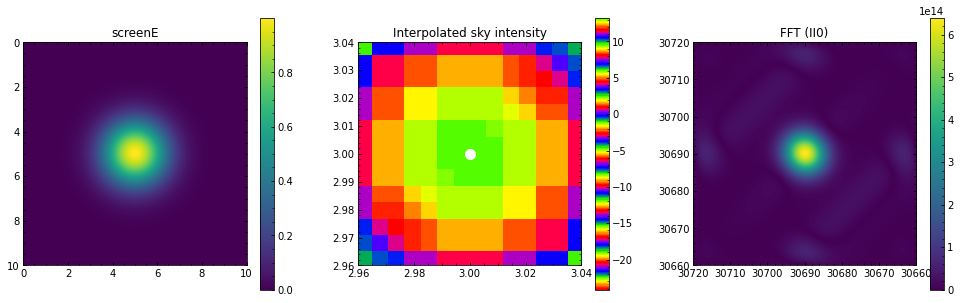

In [5]:
### check if the interpolation is centered... (see the middle subplot)
# plot screen, II0, and fft(II0)
fig = plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.imshow(screen['E'], extent=(0, screen['D'], screen['D'], 0))
plt.colorbar()
plt.title('screenE')
plt.subplot(1,3,2)
plt.imshow(np.log10(II0), extent=(0, 2*thetamaxdeg, 2*thetamaxdeg, 0), cmap='prism')
plt.plot(thetax.max()*180/np.pi/2, thetax.max()*180/np.pi/2, 'o', ms=10, color='white')
plt.xlim(2.96,3.04) # zoom in the central pixels
plt.ylim(2.96,3.04)
plt.colorbar()
plt.title('Interpolated sky intensity')
plt.subplot(1,3,3)
plt.imshow(fft_I0, extent=(-l_vec.min(), l_vec.max(), l_vec.max(), -l_vec.min()))
plt.colorbar()
plt.title('FFT (II0)')

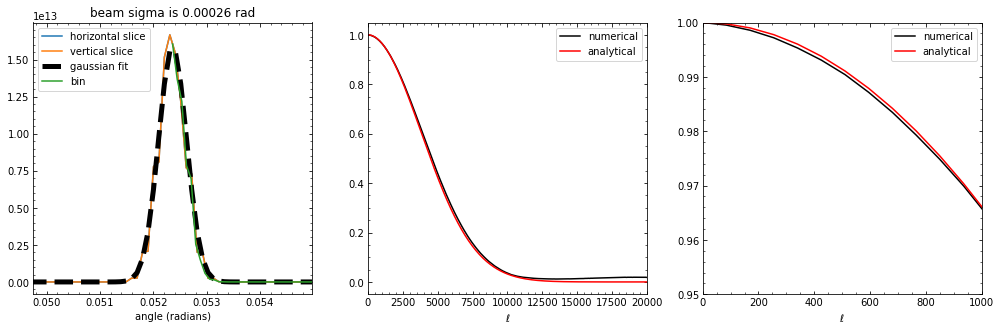

In [6]:
### compare the numerical beam window with the analytical solution
fig = plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(theta_vec, II0[int(n/2)], label='horizontal slice')
plt.plot(theta_vec, II0[:,int(n/2)], label='vertical slice')
plt.plot(theta_vec, beam_sky, ls='--', lw=5, color='black', label='gaussian fit')
plt.plot(bins[:-1]+thetax.max()/2, bin_I0, label='bin')
plt.title('beam sigma is {:.5f} rad'.format(fit[1]))
plt.xlabel('angle (radians)')
plt.xlim(0.475*theta_vec.max(), 0.525*theta_vec.max())
plt.legend(loc='upper left')
#plot analytical & numerical solutions
plt.subplot(1,3,2)
plt.plot(bin_edges[:-1], bin_mean0/bin_mean0.max(), color='black', label='numerical')
plt.plot(bin_edges, analytical(bin_edges, fit[1])/bin_mean0.max(), color='red', label='analytical')
plt.xlabel(r'$\ell$')
plt.xlim(0,20000)
plt.legend()
plt.subplot(1,3,3)
plt.plot(bin_edges[:-1], bin_mean0/bin_mean0.max(), color='black', label='numerical')
plt.plot(bin_edges, analytical(bin_edges, fit[1])/bin_mean0.max(), color='red', label='analytical')
plt.xlabel(r'$\ell$')
plt.xlim(0,1000)
plt.ylim(0.95, 1.0)
plt.legend()

# Adding errors

In [7]:

N_screen = 4096
N_theta = 1024
D = 10.0
sigma = 1.0
maxdeg = 3.0
trunc = 'y'
option = 'amp'
amp = 10.0

# measure sigma in angle (rad)
def gaussian(x, A, sigma, x0): 
  g = A*np.exp(-(x-x0)**2/(2*sigma**2))
  return(g)

def analytical(l, sigma): # blm
  fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
  return(fft)
 

# perfect gaussian create screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
  InCircle(screen, center, 2.0)
ScreenFFT(screen)

# perturbed screen
screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
MultByGaussian(screen1, center, sigma)
if trunc=='y':
  InCircle(screen1, center, 2.0)

if option=='phase':
  filter_annulus_phase(screen1, amp, 10, 12)
elif option=='amp':
  filter_annulus_amp(screen1, amp, 10, 12)
else: print('Choose phase or amplitude errors')


ScreenFFT(screen1)

# interpolation in sky intensity [rad]
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

### check numerically if FFT of the on-sky beam difference is equivalent to the difference between the two beam windows in $\ell$ space.

(440.0, 583.0)

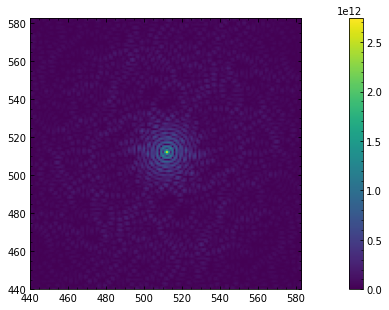

In [8]:
### FFT of the on-sky beam difference 
# FT of sky intensity
I_diff = II1 - II0
fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff))))
fft_I0 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0))) # in 1/rad space
fft_I1 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))
fig = plt.figure(figsize=(17,5))
# plt.subplot(1,4,1)
# plt.imshow(fft_I0, interpolation=None) # plot absolute value of fft_I
# plt.colorbar()
# plt.subplot(1,4,2)
# plt.imshow(fft_I1, interpolation=None) # plot absolute value of fft_I
# plt.colorbar()
# plt.subplot(1,4,3)
# plt.imshow(fft_Idiff, interpolation=None) # plot absolute value of fft_Idiff
# plt.colorbar()
# plt.subplot(1,4,4)
plt.imshow(fft_Idiff, interpolation=None) # plot absolute value of fft_Idiff
plt.colorbar()
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))



(440.0, 583.0)

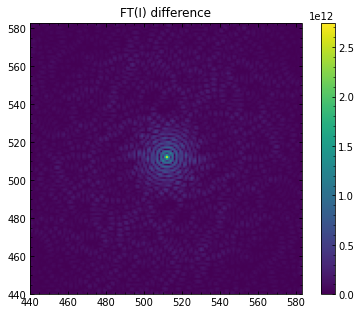

In [9]:
### difference between the perturbed and unperturbed beam windows. 
plt.imshow(np.abs(fft_I1 - fft_I0)) # plot absolute value of fft_I
plt.colorbar()
plt.title('FT(I) difference')
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))


Text(0.5, 1.0, 'difference')

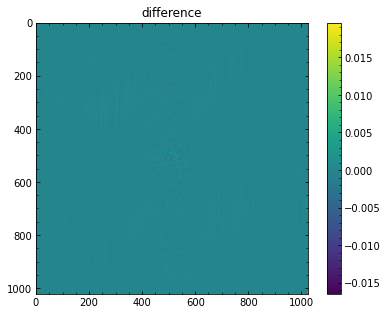

In [11]:
# difference between the two difference maps --> negligible
plt.imshow(np.abs(fft_I1 - fft_I0)-fft_Idiff, interpolation=None) # plot absolute value of fft_I
plt.colorbar()
plt.title('difference')
# plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
# plt.ylim(int(N_theta*0.43),int(N_theta*0.57))


beam sigma is 0.00027 rad


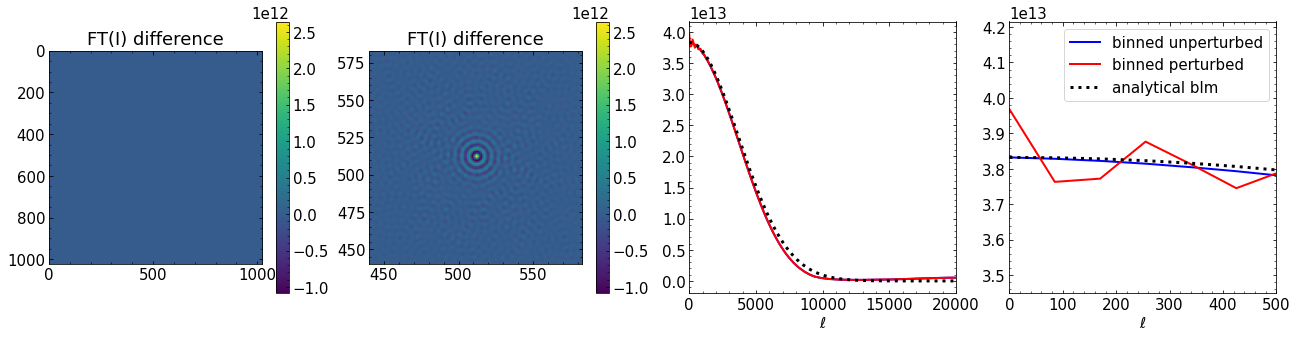

In [ ]:

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

# bin sky intensity radially
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt((thetax-thetax.max()/2)**2 + (thetay-thetay.max()/2)**2)
bins = np.linspace(0,theta_r.max(),int(len(theta_vec)/1.2))
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_I0, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bins) 

### fit 1D in sky (rad space)
### this uses the horizontal slice of data
# (fit, err) = opt.curve_fit(gaussian, theta_vec, II0[int(n/2)], p0=np.array([II0[int(n/2)].max(), 0.01, theta_vec.max()/2]), absolute_sigma=True)
# beam_sky = gaussian(theta_vec, fit[0], fit[1], fit[2])
### this uses the binned sky intensity
(fit, err) = opt.curve_fit(gaussian, bins[:-1], bin_I0, p0=np.array([II0[int(n/2)].max(), 0.01, 0.0]), absolute_sigma=True)
beam_sky = gaussian(theta_vec, fit[0], fit[1], theta_vec.max()/2)
print('beam sigma is {:.5f} rad'.format(fit[1]))

# average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(l_vec)/2))
l_flatten = l.flatten()
fft_numerical0 = fft_I0.flatten()
fft_numerical1 = fft_I1.flatten()
fft_numerical_diff = fft_Idiff.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) 
bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) 
l_vec = bin_edges[0:-1] # ell 1D vector


# plot the numerical beam and analytical beam
fig = plt.figure(figsize=(22,5))
plt.subplot(1,4,1)
plt.imshow(fft_I1 - fft_I0, interpolation=None) # plot absolute value of fft_I
plt.colorbar()
plt.title('FT(I) difference')
plt.subplot(1,4,2)
plt.imshow(fft_I1 - fft_I0, interpolation=None) # plot absolute value of fft_I
plt.colorbar()
plt.title('FT(I) difference')
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))
plt.subplot(1,4,3)
plt.plot(l_vec,bin_mean0,color='blue', lw=2, label='binned unperturbed') # normalize the numerical solution
plt.plot(l_vec,bin_mean1,color='red', lw=2, label='binned perturbed')
plt.xlabel(r'$\ell$')
plt.plot(bin_edges, analytical(bin_edges, fit[1]), color='black', lw=3, ls=':', label='analytical blm')
plt.xlim(0,2e4)
plt.subplot(1,4,4)
plt.plot(l_vec,bin_mean0,color='blue', lw=2, label='binned unperturbed') # normalize the numerical solution
plt.plot(l_vec,bin_mean1,color='red', lw=2, label='binned perturbed')
plt.xlabel(r'$\ell$')
analytic = analytical(bin_edges, fit[1])
plt.plot(bin_edges, analytic, lw=3, color='black', ls=':', label='analytical blm')
plt.xlim(0,500)
plt.ylim(0.9*analytic.max(), 1.1*analytic.max())
plt.legend()



(-10.0, 1000.0)

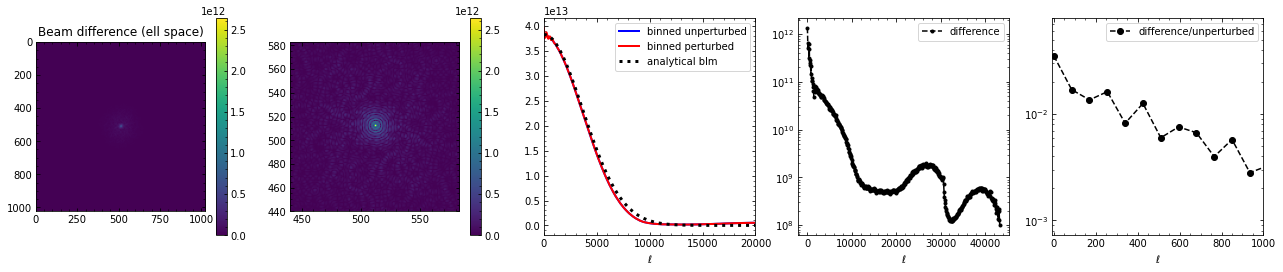

In [ ]:
# plot the difference
fig = plt.figure(figsize=(22,4))
plt.subplot(1,5,1) # take the difference in theta space, then FFT
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.title('Beam difference (ell space)')
plt.subplot(1,5,2)
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))
plt.subplot(1,5,3)
plt.plot(l_vec,bin_mean0,color='blue', lw=2, label='binned unperturbed') 
plt.plot(l_vec,bin_mean1,color='red', lw=2, label='binned perturbed')
plt.xlabel(r'$\ell$')
plt.plot(bin_edges, analytical(bin_edges, fit[1]), color='black', lw=3, ls=':', label='analytical blm')
plt.xlim(0,2e4)
plt.legend();
plt.subplot(1,5,4) 
plt.semilogy(l_vec,bin_mean_diff, 'o--', ms=3,color='black', label='difference') 
plt.xlabel(r'$\ell$')
plt.legend()
#plt.xlim(-10,2e4)
plt.subplot(1,5,5) # relative difference
plt.semilogy(l_vec,bin_mean_diff/bin_mean0,'o--', color='black', label='difference/unperturbed') 
plt.xlabel(r'$\ell$')
plt.legend()
plt.xlim(-10,1000)

